In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import geopandas as gp
import rasterio as rio
from rasterio.mask import mask
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.pyplot import figure
import pandas as pd
from tqdm import tqdm # barra de progresso
import pyproj
from netCDF4 import Dataset
import json
import shapely
import rasterio.features
from rasterio import features
from rasterio.merge import merge
from rasterio.coords import BoundingBox
import warnings
import glob
import os

# MCD12Q1 - MODIS Landcover

## Get data

Get MCD12Q1 files (Julia):

In [3]:
path_lc = Path('K:\Programming\Fire_Brazil\DerivedData\Landcover\MCD12Q1_006_1km') # Path landcover

In [4]:
lc_files = list(path_lc.iterdir())
lc_files = [o for o in lc_files if o.suffix=='.tif'] # Windows Path

In **2001** and **2018** (first and last evaluated years)

In [5]:
lc_2001 = lc_files[0]
lc_2018 = lc_files[17]

Get ecoregions shapefile:

In [6]:
path_eco = Path('K:\Programming\Fire_Brazil\Research\Projects\Trends_Cerrado\Data\ECORREGIOES CERRADO') # Path eco regions

In [7]:
ecoshape = path_eco/'ECORREGIOES_CERRADO_V7.shp'
eco_df = gp.read_file(ecoshape)

In [8]:
eco_df = eco_df.to_crs({'init':'epsg:4326'}) # change eco regions projection to WGS84 (same as MODIS)

C:\Users\pssilva\Anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [9]:
region_names = eco_df.NOME.values 

## Functions

Function to crop MCD12Q1 file to each ecoregion:

In [10]:
def mask_crop(file, region_name):
    filep = rio.open(file) 
    geometry = eco_df.loc[eco_df.NOME == region_name, 'geometry'].values[0] 
    out, transform = mask(filep, shapes=[geometry], crop=True) 
    return out

Function to apply <a href="https://en.wikipedia.org/wiki/Largest_remainder_method">Largest Remainder Method algorithm</a> and get 100% totals per ecoregion (based on <a href="https://revs.runtime-revolution.com/getting-100-with-rounded-percentages-273ffa70252b">this page</a>):

In [11]:
def LRM_algorithm(array): # Largest Remainder Method algorithm
    rounded_values = np.floor(array) # rounding down all values
    diff = 100 - rounded_values.sum().values[0] # difference between the sum of the rounded values and total value
    decimals = abs(np.floor(array) - array) # getting decimal parts
    array['decimals'] = decimals # new column on array
    sorted_array = array.sort_values('decimals',ascending=False) # sort whole dataframe as descending decimal values
    
    for index in range(0,array_int.shape[0]): 
        number = sorted_array.iloc[index][0]
        if index <= (diff-1): # if remaining percentage, distribute over highst decimal values
            sorted_array = sorted_array.replace(number, (np.floor(number)+1))
        else: # otherwise round down
            sorted_array = sorted_array.replace(number, (np.floor(number)))
            
    new_array = sorted_array.sort_index() # sort dataframe by index
    new_array = pd.DataFrame.drop(new_array, columns=['decimals']) # remove extra column
    return new_array

## Get landcover per ecoregion 

Getting landcover percentages per ecoregion: for 2001 and 2018.

In [12]:
lc_dict = {r:[] for r in region_names} # dictionary with results
lc_str =  ["Npixels"] + [str(x) for x in range(17 + 1)] # string with indexes names

for region_name in region_names:
    total = mask_crop(lc_2018, region_name).squeeze() # cropping in ecoregion
    lc_dict[region_name].append(total.size) # total number of pixels 
    for j in range(0,17+1): # number of each landcover category
        ii = np.where(total == j)[0].size # number of pixels with that landcover category
        lc_dict[region_name].append(ii) # append in dictionary
df = pd.DataFrame(lc_dict, index=lc_str) # to dataframe

Number of pixels in region (total minus values 0):

In [13]:
Npixels = df.loc["Npixels", :]
Nonregion = df.loc["0", :]
regvalues = Npixels.values-Nonregion.values

Normalize:

In [14]:
df_perc = ((df/regvalues)*100)

In [15]:
df_perc = pd.DataFrame.drop(df_perc, index=['Npixels','0']) # remove Npixels and 0 (nonregion) columns 

Round values up to 100%

Plotting:

In [17]:
# Colormap
b = [
    [0.59607843, 0.8745098, 0.54117647],[0.17254902, 0.62745098, 0.17254902], #Gr
    [1.        , 0.59607843, 0.58823529],[0.83921569, 0.15294118, 0.15686275], #Rd
    [0.96862745, 0.71372549, 0.82352941], # light Pk
    [0.76862745, 0.61176471, 0.58039216],[0.54901961, 0.3372549, 0.29411765], #Br
    [1.        , 0.73333333, 0.47058824],[1.        , 0.49803922, 0.05490196], #Or
    [0.7372549 , 0.74117647, 0.13333333], #weird looking green
    [0.68235294, 0.78039216, 0.90980392], # light Bl
    [0.77254902, 0.69019608, 0.83529412],[0.58039216, 0.40392157, 0.74117647], #Pr
    [0.89019608, 0.46666667, 0.76078431], # hard Pk
    [0.78039216, 0.78039216, 0.78039216],[0.49803922, 0.49803922, 0.49803922], #BW
    [0.12156863, 0.46666667, 0.70588235], # hard Bl
    ] 
newcmp = ListedColormap(b)

In [18]:
legend_str = ["Evergreen Needleleaf Forests", "Evergreen Broadleaf Forests","Deciduous Needleleaf Forests",
              "Deciduous Broadleaf Forests","Mixed Forests","Closed Shrublands","Open Shrublands","Woody Savannas",
              "Savannas","Grasslands","Permanent Wetlands","Croplands","Urban and Built-up Lands",
              "Cropland/Natural Vegetation Mosaics","Permanent Snow and Ice","Barren","Water Bodies"]

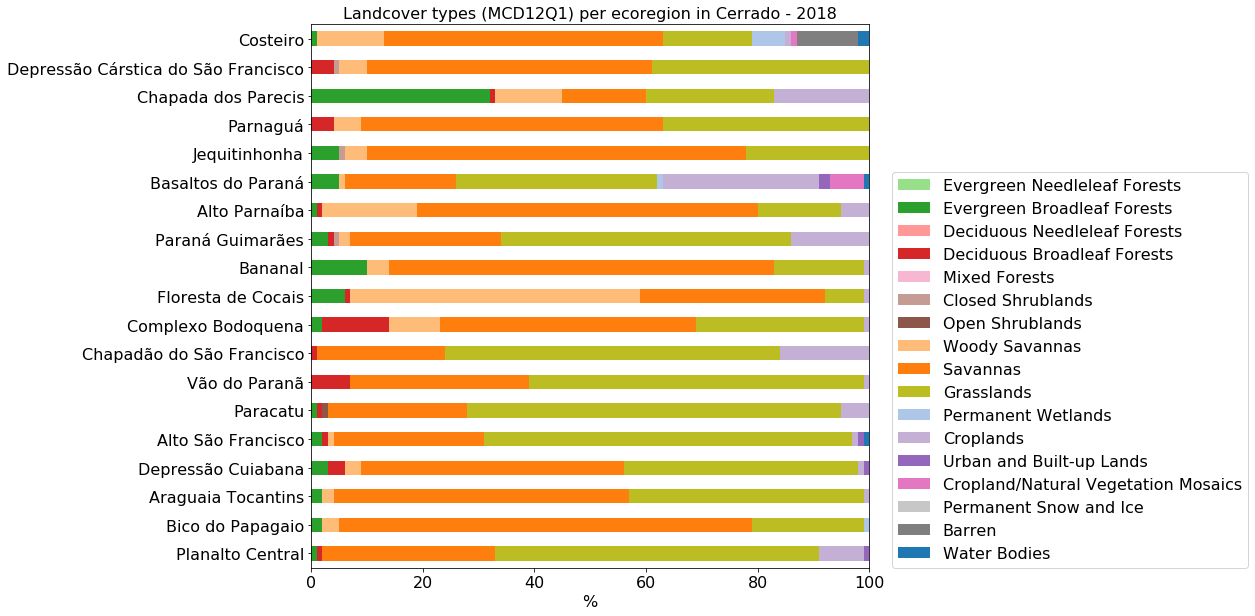

In [19]:
df_perc = df_perc.T;

ax = df_perc.plot.barh(figsize=(10,10),stacked=True,cmap=newcmp,fontsize = 16)
plt.title('Landcover types (MCD12Q1) per ecoregion in Cerrado - 2018',fontsize = 16)
ax.set_xlabel("%",fontsize = 16)
ax.set_xlim(0,100)
ax.legend(legend_str,loc=(1.04,0),fontsize = 16)

# Getting burned landcover percentages

Get MCD64 files (Julia):

In [20]:
path_ba = Path('K:\Programming\Fire_Brazil\RawData\BurnedArea\MODIS\MCD64_V6') 

In [21]:
ba_files = list(path_ba.iterdir())
ba_files = [o for o in ba_files if o.suffix=='.tif']

## Binary data

Create new files for MCD64 with: 0 is not burnt; 1 if burnt

Save result as TIF:

In [22]:
def save_tif(Z,filename):
    with rasterio.open(
        filename,
        'w',
        driver='GTiff',
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype='float64',
        crs=rio.crs.CRS.from_epsg(4326),
        transform=example.transform,
    ) as dst:
        dst.write(Z, 1)

In [23]:
example = rio.open(ba_files[1]) # Get transform to save

## Yearly files

Get repeated values, i.e., number of pixels that burned more than once per year:

In [24]:
def yearly_repeated_values(yearly_array):
    rep_array = np.zeros((1,11+1))
    for mm in range(1,12+1):
        ii = np.where(yearly_array == mm)[0].size # number of pixels with that landcover category
        rep_array[0,mm-1] = ii
    return rep_array

Get yearly files (TIF) of MCD64 BA and save repeated values per year:

### Sum all years

Get a file with total BA over 2001-2018:

## Burnt landcover values

In [25]:
path_ba_binary = Path('K:\Programming\Fire_Brazil\RawData\BurnedArea\MODIS\MCD64_V6\\asBinary\yearly')

In [26]:
ba_binary_files = list(path_ba_binary.iterdir())
ba_binary_files = [o for o in ba_binary_files if o.suffix=='.tif']

In [88]:
lc_str =  ["Npixels"] + [str(x) for x in range(17 + 1)] # string with indexes names

In [92]:
result_dict = {r:[] for r in region_names} # dictionary with results 

for region_name in tqdm(region_names):
    yearly_dict = {str(r):[] for r in range(2001,2018+1)} # dictionary with results
    
    for yy in range(0,17+1):
        ba = mask_crop(ba_binary_files[yy], region_name).squeeze() # cropping in ecoregion
        lc = mask_crop(lc_files[yy], region_name).squeeze() # cropping in ecoregion
        if ba.size != lc.size: print('Error! Different sizes in ba and lc') 
            
        bpixels = np.where(ba == 1)[0].size
        yearly_dict[str(2000+yy+1)].append(bpixels) # total number of pixels
        
        new = ba*lc # landcover that burns
        if new.all()>17 or new.all()<0: print('Error! Incorrect lc values')
        
        for j in range(0,17+1): # number of each landcover category
            ii = np.where(new == j)[0].size # number of pixels with that landcover category
            yearly_dict[str(2000+yy+1)].append(ii) # append in dictionary
    
    aux = pd.DataFrame(yearly_dict, index=lc_str) # to dataframe
    aux2 = np.array(aux.T.sum())
    
    for j in range(0,18+1): # number of each landcover category plus total number of pixels
        result_dict[region_name].append(aux2[j]) # append in dictionary
        
df = pd.DataFrame(result_dict, index=lc_str) # to dataframe
df = pd.DataFrame.drop(df, index=['0']) # remove 0 (nonregion and not burned pixels) columns

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:05<00:00,  3.45s/it]


*Verifiquei e Npixels = sum of all other burnt landcover values*

Normalize:

In [97]:
Npixels = df.loc["Npixels", :]

In [120]:
df_perc = ((df/Npixels)*100)
df_perc = pd.DataFrame.drop(df_perc, index=['Npixels']) # remove 0 (nonregion and not burned pixels) columns

In [121]:
df_perc

,Planalto Central,Bico do Papagaio,Araguaia Tocantins,Depressão Cuiabana,Alto São Francisco,Paracatu,Vão do Paranã,Chapadão do São Francisco,Complexo Bodoquena,Floresta de Cocais,Bananal,Paraná Guimarães,Alto Parnaíba,Basaltos do Paraná,Jequitinhonha,Parnaguá,Chapada dos Parecis,Depressão Cárstica do São Francisco,Costeiro
1,0.000865,0.000000,0.000276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.579229,1.408182,0.857029,0.622693,0.507856,0.223784,0.216035,0.144506,0.305846,3.004005,1.798044,1.121255,1.210024,0.889510,2.612428,0.040941,5.604428,0.083743,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.659629,1.027953,0.623043,3.235163,0.737978,1.676416,7.121139,0.356082,26.318235,1.840135,0.065099,3.707497,1.499249,0.084496,0.839709,4.662321,2.928115,7.771326,0.000000
5,0.285292,0.129927,0.356773,0.592268,0.079352,0.282674,0.448072,0.028657,0.027100,0.162536,0.030814,1.212000,0.161951,0.016899,0.093301,0.088432,0.351671,0.066994,0.000000
6,0.016426,0.097445,0.000552,0.000000,0.031741,0.098151,0.000000,0.032925,0.000000,0.000000,0.000000,0.047435,0.001476,0.013827,0.037320,0.006551,0.010625,0.279142,0.000000
7,0.054465,0.000000,0.011037,0.058821,0.222187,0.573201,0.024004,0.019511,0.000000,0.000000,0.000000,0.164992,0.000000,0.016899,0.000000,0.042578,0.005312,0.000000,0.000000
8,0.489319,1.333665,1.478416,2.951199,0.420568,0.321935,0.064010,0.240234,34.343786,58.097754,0.654032,0.940452,11.303026,0.215080,4.478447,4.732739,9.971101,7.882983,6.870229
9,55.888684,70.634542,61.590166,51.821427,33.502619,21.793412,41.934710,27.408586,32.663569,26.470076,81.315615,47.312013,65.820142,10.989062,78.876656,53.771453,20.276875,70.221081,81.297710
10,38.062263,25.217341,34.633776,40.381729,61.807650,67.406070,49.935990,64.768577,5.787844,8.982992,15.094806,28.551099,15.283931,21.110121,13.024818,36.651710,53.953380,13.594238,7.251908


In [122]:
df_perc = df_perc.T;

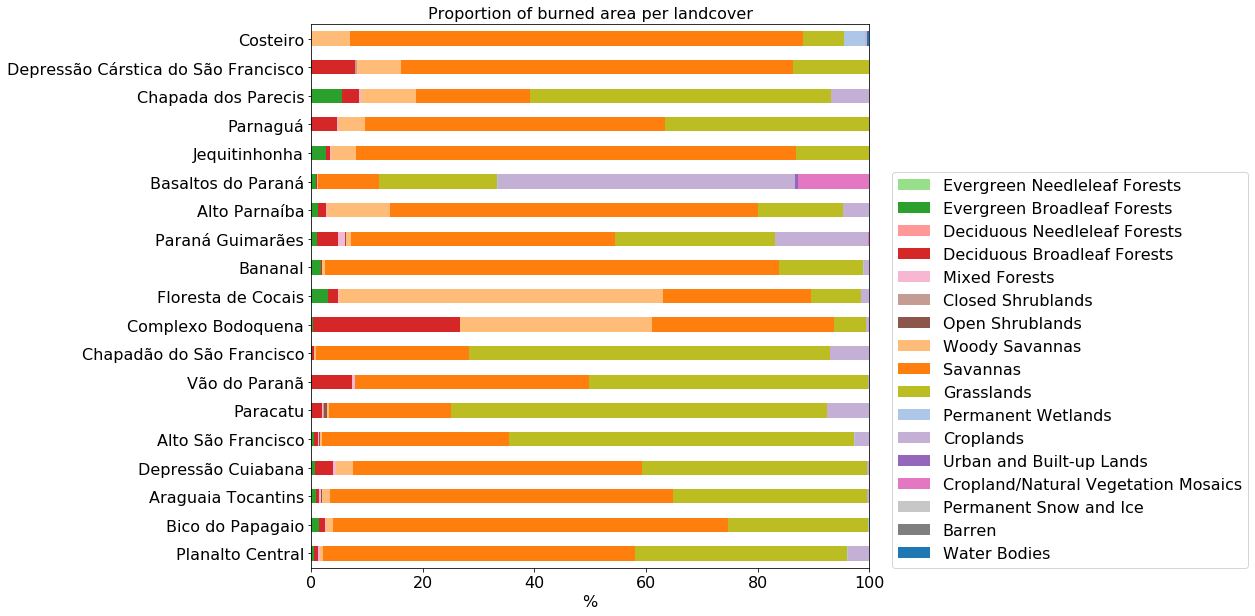

In [125]:
ax = df_perc.plot.barh(figsize=(10,10),stacked=True,cmap=newcmp,fontsize = 16)
plt.title('Proportion of burned area per landcover',fontsize = 16)
ax.set_xlabel("%",fontsize = 16)
#ax.set_xlim(0,100)
ax.legend(legend_str,loc=(1.04,0),fontsize = 16)

In [131]:
eco_df

,NOME,CLASSIFY,AREA_HA,SEQUENCIA,AREA,gpp_mean,gpp_stdev,geometry
0,Planalto Central,Planalto,1.756223e+07,18,1.695516e+07,320.085319,60.766583,"MULTIPOLYGON (((-47.80548 -18.53702, -47.78863..."
1,Bico do Papagaio,Depressão,5.385545e+06,6,5.385545e+06,364.562531,47.372341,"POLYGON ((-47.32110 -5.34146, -47.32065 -5.342..."
2,Araguaia Tocantins,Depressão,2.855790e+07,3,2.855790e+07,280.477211,35.976998,"POLYGON ((-46.92355 -7.92754, -46.92400 -7.925..."
3,Depressão Cuiabana,Depressão,4.517872e+06,12,4.517872e+06,178.093071,73.690587,"POLYGON ((-52.83497 -14.25524, -52.83827 -14.2..."
4,Alto São Francisco,Planalto,8.166454e+06,2,7.958544e+06,347.618892,70.878265,"POLYGON ((-44.59538 -17.39278, -44.58383 -17.3..."
5,Paracatu,Depressão,9.362631e+06,15,9.362631e+06,337.436122,40.726570,"POLYGON ((-46.94203 -15.28036, -46.94136 -15.2..."
6,Vão do Paranã,Depressão,2.061524e+06,19,2.061524e+06,316.565558,30.709116,"POLYGON ((-46.94203 -15.28036, -46.94504 -15.2..."
7,Chapadão do São Francisco,Planalto,1.186298e+07,8,1.186298e+07,299.275662,36.492803,"POLYGON ((-44.42668 -12.04426, -44.43258 -12.0..."
8,Complexo Bodoquena,Depressão,4.037179e+06,9,4.037179e+06,106.674402,42.258910,"POLYGON ((-55.77513 -20.22295, -55.77166 -20.2..."
9,Floresta de Cocais,Depressão,7.480792e+06,13,7.480792e+06,455.384833,65.526494,"POLYGON ((-41.99333 -2.86880, -41.99329 -2.869..."
